<a href="https://colab.research.google.com/github/poets-ai/elegy/blob/master/docs/getting-started/low-level-api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started: Low Level API

Elegy's low-level API works similar to the [Pytorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning) API or [Keras Custom Training](https://keras.io/guides/customizing_what_happens_in_fit/) and has the following features:

* Its functional: it uses a simple functional state management pattern so it should be compatible with all jax features.
* Its framework agnostic: since its just Jax you can use any Jax framework like Flax, Haiku, Objax, etc, or even just use pure Jax.
* Its very flexible: you get to define everything from how predictions, losses, metrics, gradients, parameters update, etc, are calculated, this is more ideal for research or less standar training procedures like Adversarial Training.

Before getting started lets install some dependencies and define some styles for the notebook:

In [ ]:
! pip install --upgrade pip
! pip install elegy datasets matplotlib
# For GPU install proper version of your CUDA, following will work in COLAB:
# ! pip install --upgrade jax jaxlib==0.1.59+cuda101 -f https://storage.googleapis.com/jax-releases/jax_releases.html

In [ ]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

**Note:** that Elegy depends on the jax CPU version hosted on Pypi, if you want to run jax on GPU you will need to [install it](https://github.com/google/jax#installation) separately. If you are running this example on Colab, jax is already preinstalled but you can uncomment the last line of the previous cell if you want to update it.

## Loading the Data
In this tutorial we will train a Neural Network on the MNIST dataset, for this we will first need to download and load the data into memory. Here we will use `dataget` for simplicity but you can use you favorite datasets library.

In [1]:
from datasets.load import load_dataset
import numpy as np

dataset = load_dataset("mnist")
dataset.set_format("np")
X_train = np.stack(dataset["train"]["image"])[..., None]
y_train = dataset["train"]["label"]
X_test = np.stack(dataset["test"]["image"])[..., None]
y_test = dataset["test"]["label"]

print("X_train:", X_train.shape, X_train.dtype)
print("y_train:", y_train.shape, y_train.dtype)
print("X_test:", X_test.shape, X_test.dtype)
print("y_test:", y_test.shape, y_test.dtype)

Reusing dataset mnist (/home/cris/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4)


  0%|          | 0/2 [00:00<?, ?it/s]

X_train: (60000, 28, 28, 1) uint8
y_train: (60000,) int64
X_test: (10000, 28, 28, 1) uint8
y_test: (10000,) int64


In this case `dataget` loads the data from Yann LeCun's website.

## Defining a simple Model

The low-level API lets you redefine what happens during the various stages of training, evaluation and inference by implementing some methods in a custom class. Here is the list of methods you can define along with the high-level method that uses it:

| Low-level Method | High-level Method | 
| :- | :- |
| `pred_step` | `predict` |
| `test_step` | `evaluate` |
| `grad_step` | NA |
| `train_step` | `fit` |

Check out the guides on the low-level API for more information.

In this tutorial we are going to implement Linear Classifier using pure Jax by overriding`pred_step` which defines the forward pass and `test_step` which defines loss and metrics of our model. 

`pred_step` returns a tuple with:
* `y_pred`: predictions of the model
* `states`: a `elegy.States` namedtuple that contains the states for thing like network trainable parameter, network states, metrics states, optimizer states, rng state.

`test_step` returns a tuple with:
* `loss`: the scalar loss use to calculate the gradient
* `logs`: a dictionary with the logs to be reported during training
* `states`: a `elegy.States` namedtuple that contains the states for thing like network trainable parameter, network states, metrics states, optimizer states, rng state.

Since Jax is functional you will find that low-level API is very explicit with state management, that is, you always get the currrent state as input and you return the new state as output. Lets define `test_step` to make things clearer:

In [2]:
import jax
import numpy as np
import jax.numpy as jnp
import typing as tp
import elegy as eg

M = tp.TypeVar("M", bound=eg.Model)

class LinearClassifier(eg.Model):
    w: jnp.ndarray = eg.Parameter.node()
    b: jnp.ndarray = eg.Parameter.node()

    def __init__(
        self,
        features_out: int,
        loss: tp.Any = None,
        metrics: tp.Any = None,
        optimizer=None,
        seed: int = 42,
        eager: bool = False,
    ):
        self.features_out = features_out
        super().__init__(
            loss=loss,
            metrics=metrics,
            optimizer=optimizer,
            seed=seed,
            eager=eager,
        )

    def init_step(self: M, key: jnp.ndarray, inputs: jnp.ndarray) -> M:
        features_in = np.prod(inputs.shape[1:])

        self.w = jax.random.uniform(
            key,
            shape=[
                features_in,
                self.features_out,
            ],
        )
        self.b = jnp.zeros([self.features_out])

        assert self.optimizer is not None
        self.optimizer = self.optimizer.init(self)

        return self

    def pred_step(self: M, inputs: tp.Any) -> eg.PredStepOutput[M]:
        # flatten + scale
        inputs = jnp.reshape(inputs, (inputs.shape[0], -1)) / 255

        # linear
        logits = jnp.dot(inputs, self.w) + self.b
        
        return logits, self

    def test_step(
        self: M,
        inputs,
        labels,
    ) -> eg.TestStepOutput[M]:
        model = self

        # forward
        logits, model = model.pred_step(inputs)

        # crossentropy loss
        target = jax.nn.one_hot(labels["target"], self.features_out)
        loss = jnp.mean(-jnp.sum(target * jax.nn.log_softmax(logits), axis=-1))

        # metrics
        logs = dict(
            acc=jnp.mean(jnp.argmax(logits, axis=-1) == labels["target"]),
            loss=loss,
        )

        return loss, logs, model

Notice the following:
* We define a bunch of arguments with specific names, Elegy uses Dependency Injection so you can just request what you need.
* `initializing` tells us if we should initialize our parameters or not, here we are directly creating them ourselves but if you use a Module system you can conditionally call its `init` method here.
* Our model is defined by a simple linear function.
* Defined a simple crossentropy loss and an accuracy metric, we added both the the logs.
* We set the updated `States.net_params` with the `w` and `b` parameters so we get them as an input on the next run after they are initialized.
* `States.update` offers a clean way inmutably update the states without having to copy all fields to a new States structure.

Remember `test_step` only defines what happens during `evaluate`, however, `Model`'s default implementation has a structure where on method is defined in terms of another:

```
pred_step ⬅ test_step ⬅ grad_step ⬅ train_step
```

Because of this, we get the `train_step` / `fit` for free if we just pass an optimizer to the the constructor as we are going to do next:

In [3]:
import optax

model = LinearClassifier(
    features_out=10,
    optimizer=optax.adam(1e-3)
)

## Training the Model
Now that we have our model we can just call `fit`. The following code will train our model for `100` epochs while limiting each epoch to `200` steps and using a batch size of `64`:

In [ ]:
history = model.fit(
    inputs=X_train,
    labels=y_train,
    epochs=100,
    steps_per_epoch=200,
    batch_size=64,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[eg.callbacks.ModelCheckpoint("models/low-level", save_best_only=True)],
)

```
...
Epoch 99/100
199/200 [============================>.] - 0s 1ms/step - acc: 0.9375 - loss: 0.2630 - val_acc: 0.8594 - val_loss: 0.3883
Epoch 100/100
200/200 [==============================] - ETA: 0s - acc: 0.9688 - loss: 0.143 - 0s 994us/step - acc: 0.9688 - loss: 0.1924 - val_acc: 0.8750 - val_loss: 0.4010                 
```

The `elegy.callbacks.ModelCheckpoint` callback will periodicall saves the model a folder called `"models/low-level"` during training which is very useful if we want to load it after the process is finished, we will use it later.`fit` returns a `History` object which which contains information the time series for the values of the losses and metrics throughout training, we can use it to generate some nice plots of the evolution of our training:

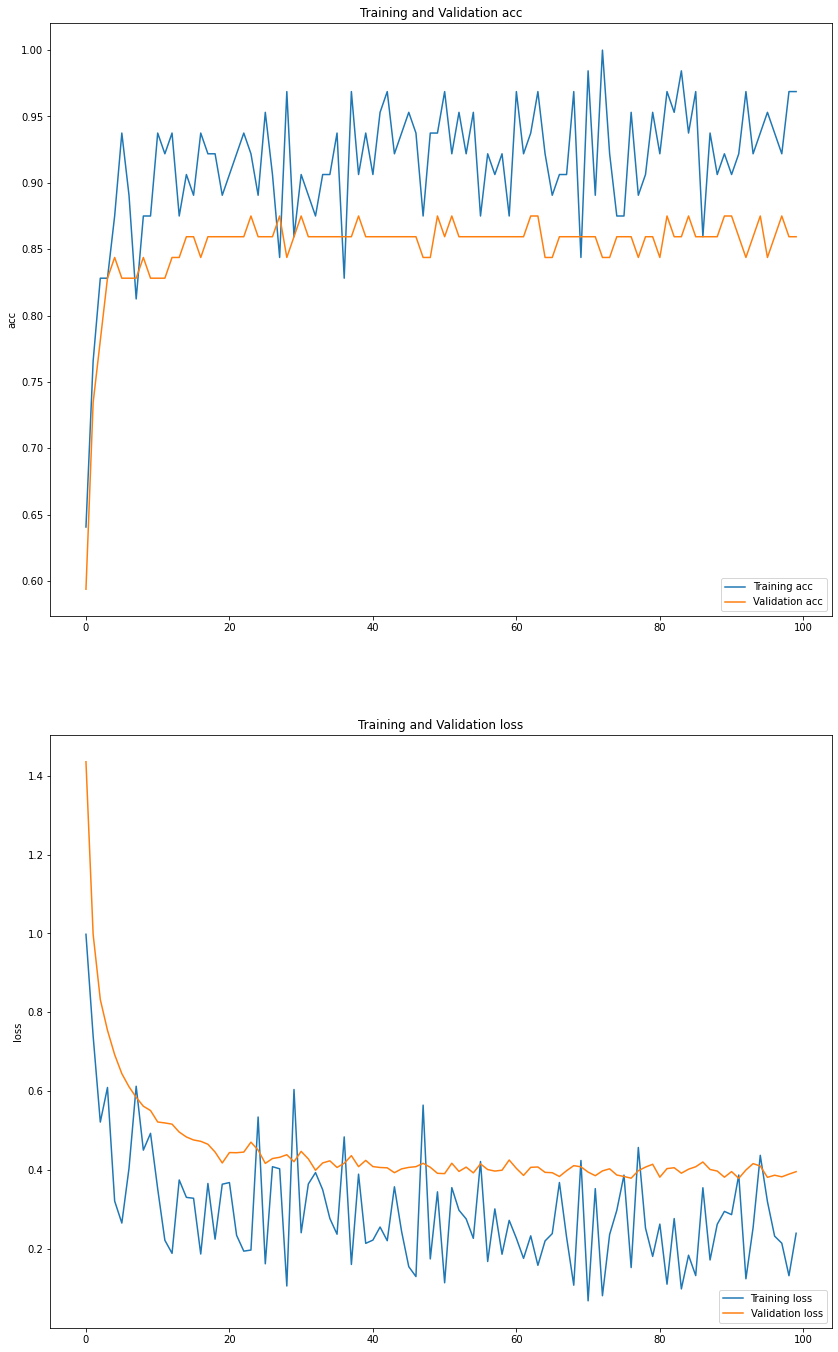

In [5]:
import matplotlib.pyplot as plt

def plot_history(history):
    n_plots = len(history.history.keys()) // 2
    plt.figure(figsize=(14, 24))
    
    for i, key in enumerate(list(history.history.keys())[:n_plots]):
        metric = history.history[key]
        val_metric = history.history[f"val_{key}"]

        plt.subplot(n_plots, 1, i + 1)
        plt.plot(metric, label=f"Training {key}")
        plt.plot(val_metric, label=f"Validation {key}")
        plt.legend(loc="lower right")
        plt.ylabel(key)
        plt.title(f"Training and Validation {key}")
    plt.show()
    
plot_history(history)

Notice that the logs are very noisy, this is because for this example we didn't use cummulative metrics so the reported value is just the value for the last batch of that epoch, not the value for the entire epoch. To fix this we could use some of the modules in `elegy.metrics`.

## Generating Predictions

Having trained our model we can now get some samples from the test set and generate some predictions. First we will just pick some random samples using `numpy`:

In [6]:
import numpy as np

idxs = np.random.randint(0, 10000, size=(9,))
x_sample = X_test[idxs]

In [7]:
x_sample.shape

(9, 28, 28, 1)

Here we selected `9` random images. Now since we had implemented `pred_step` we can used `predict`:

In [8]:
y_pred = model.predict(x_sample)
y_pred.shape

(9, 10)

Easy right? Finally lets plot the results to see if they are accurate.

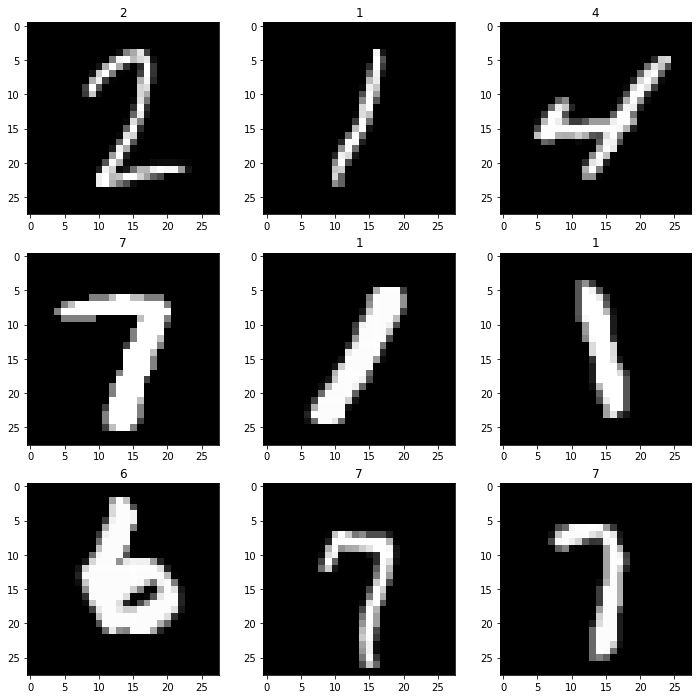

In [9]:
plt.figure(figsize=(12, 12))
for i in range(3):
    for j in range(3):
        k = 3 * i + j
        plt.subplot(3, 3, k + 1)
    
        plt.title(f"{np.argmax(y_pred[k])}")
        plt.imshow(x_sample[k], cmap="gray")

Good enough!

## Serialization
To serialize the `Model` you can use the `model.save(...)`, this will create a folder with some files that contain the model's code plus all parameters and states, however since we had previously used the `ModelCheckpoint` callback we can load it using `elegy.load`. Lets get a new model reference containing the same weights and call its `evaluate` method to verify it loaded correctly:

In [10]:
# You can use can use `save` but `ModelCheckpoint already serialized the model
# model.save("model")

# current model reference
print("current model id:", id(model))

# load model from disk
model = eg.load("models/low-level")

# new model reference
print("new model id:    ", id(model))

# check that it works!
model.evaluate(x=X_test, y=y_test)

current model id: 140168717441584
new model id:     140168135981184
313/313 [==============================] - 0s 1ms/step - acc: 0.9265 - loss: 0.2704


{'acc': DeviceArray(0.9375, dtype=float32),
 'loss': DeviceArray(0.10284138, dtype=float32),
 'size': 32}

### Saved Models

You can also serialize your Elegy Model as a TensorFlow SavedModel which is portable to many platforms many platforms and services, to do this you can use the `saved_model` method. `saved_model` will convert the function that creates the predictions for your Model (`pred_step`) in Jax to a TensorFlow version via `jax2tf` and then serialize it to disk.

In [11]:
model.saved_model(x_sample, "saved-models/low-level")

INFO:tensorflow:Assets written to: saved-models/low-level/assets


INFO:tensorflow:Assets written to: saved-models/low-level/assets


As you can see`saved_model` accepts a sample to infer the shapes, the path where the model will be saved at, and a list of batch sizes for the different signatures it accepts. Due to some current limitations in Jax it is not possible to create signatures with dynamic dimensions so you must specify a couple which might fit you needs. 

We can test our saved model by loading it with TensorFlow and generating a couple of predictions as we did previously:

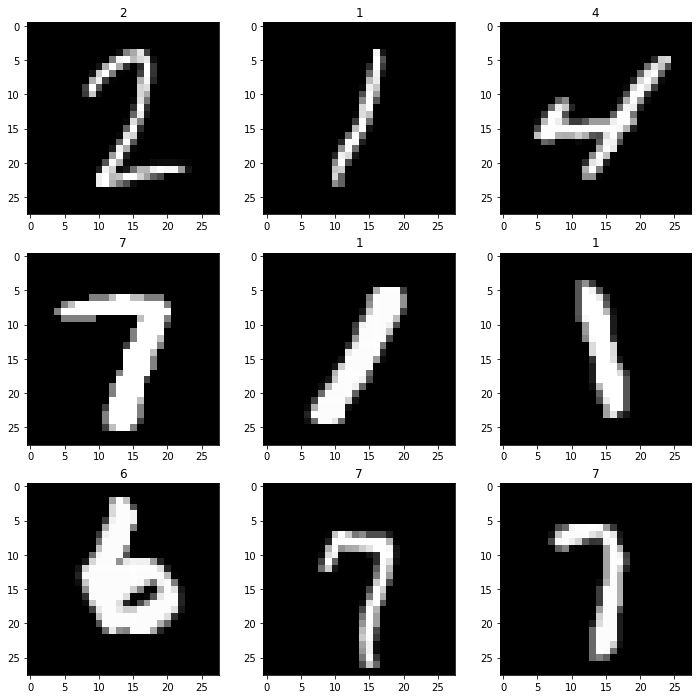

In [13]:
import tensorflow as tf

saved_model = tf.saved_model.load("saved-models/low-level")

y_pred_tf = saved_model(x_sample.astype(np.uint8))

plt.figure(figsize=(12, 12))
for i in range(3):
    for j in range(3):
        k = 3 * i + j
        plt.subplot(3, 3, k + 1)
    
        plt.title(f"{np.argmax(y_pred_tf[k])}")
        plt.imshow(x_sample[k], cmap="gray")

Excellent! We hope you've enjoyed this tutorial.